# **Notebook 03: Feature Engineering**

## Objectives
- Investigate potential feature transformations
- Create derived features to enhance predictive power
- Encode categorical variables (one-hot encoding)
- Scale numerical features
- Perform train/test split
- Save transformers for pipeline reuse

## Inputs
- `outputs/datasets/cleaned/leads_cleaned.csv`

## Outputs
- `outputs/datasets/engineered/leads_engineered.csv`
- `outputs/datasets/engineered/X_train.csv`
- `outputs/datasets/engineered/X_test.csv`
- `outputs/datasets/engineered/y_train.csv`
- `outputs/datasets/engineered/y_test.csv`

---

## Change Working Directory

In [1]:
import os

current_dir = os.getcwd()
os.chdir(os.path.dirname(current_dir))
print(f"Working directory: {os.getcwd()}")

Working directory: /Users/anthony/Downloads/Project-5-main


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import joblib
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

---

## Load Cleaned Dataset

In [3]:
df = pd.read_csv('outputs/datasets/cleaned/leads_cleaned.csv')
print(f"Dataset loaded: {df.shape[0]} rows x {df.shape[1]} columns")

Dataset loaded: 7874 rows x 32 columns


---

## Step 1: Investigate Feature Distributions

Before transformations, let's understand the distribution of key numerical features.

In [4]:
# Identify numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != 'Converted']

print("Numerical columns:")
print(numerical_cols)

Numerical columns:
['Do Not Email', 'Do Not Call', 'TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 'Newspaper', 'Digital Advertisement', 'Through Recommendations', 'Receive More Updates About Our Courses', 'Update me on Supply Chain Content', 'Get updates on DM Content', 'Asymmetrique Activity Score', 'Asymmetrique Profile Score', 'I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']


In [5]:
# Check skewness of numerical features
print("\nSkewness Analysis:")
print("=" * 50)
for col in numerical_cols:
    if df[col].dtype in ['int64', 'float64'] and col != 'Converted':
        skew = df[col].skew()
        recommendation = ""
        if abs(skew) > 1:
            recommendation = "(Consider log transformation - high skewness)"
        elif abs(skew) > 0.5:
            recommendation = "(Moderately skewed)"
        else:
            recommendation = "(Approximately normal)"
        print(f"{col}: {skew:.2f} {recommendation}")


Skewness Analysis:
Do Not Email: 2.91 (Consider log transformation - high skewness)
Do Not Call: 62.73 (Consider log transformation - high skewness)
TotalVisits: 20.97 (Consider log transformation - high skewness)
Total Time Spent on Website: 0.76 (Moderately skewed)
Page Views Per Visit: 3.46 (Consider log transformation - high skewness)
Search: 23.66 (Consider log transformation - high skewness)
Magazine: 0.00 (Approximately normal)
Newspaper Article: 62.73 (Consider log transformation - high skewness)
X Education Forums: 88.74 (Consider log transformation - high skewness)
Newspaper: 88.74 (Consider log transformation - high skewness)
Digital Advertisement: 44.34 (Consider log transformation - high skewness)
Through Recommendations: 33.50 (Consider log transformation - high skewness)
Receive More Updates About Our Courses: 0.00 (Approximately normal)
Update me on Supply Chain Content: 0.00 (Approximately normal)
Get updates on DM Content: 0.00 (Approximately normal)
Asymmetrique Act

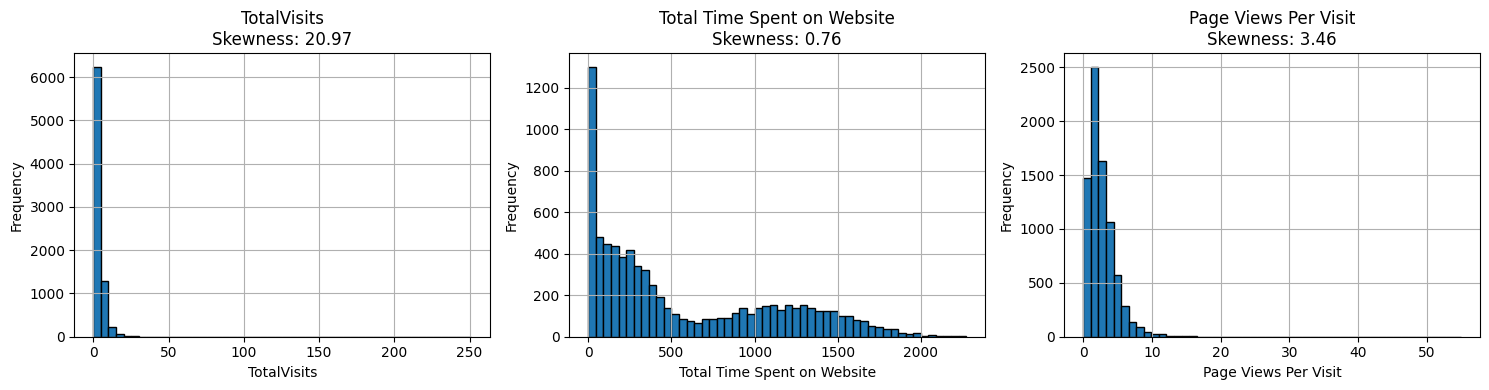

In [6]:
# Visualize distributions of key behavioural features
key_features = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit']
key_features = [f for f in key_features if f in df.columns]

if key_features:
    fig, axes = plt.subplots(1, len(key_features), figsize=(15, 4))
    if len(key_features) == 1:
        axes = [axes]
    
    for ax, col in zip(axes, key_features):
        df[col].hist(bins=50, ax=ax, edgecolor='black')
        ax.set_title(f'{col}\nSkewness: {df[col].skew():.2f}')
        ax.set_xlabel(col)
        ax.set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.savefig('outputs/figures/feature_distributions.png', dpi=150)
    plt.show()

---

## Step 2: Create Derived Features

Creating new features that might capture additional patterns.

In [7]:
# Create copy for engineering
df_eng = df.copy()

print("Creating derived features...")
print("=" * 50)

Creating derived features...


In [8]:
# Feature 1: Engagement Score (composite metric)
# Combines time spent, visits, and page views into single score
if all(col in df_eng.columns for col in ['Total Time Spent on Website', 'TotalVisits', 'Page Views Per Visit']):
    # Normalize each component before combining
    time_norm = (df_eng['Total Time Spent on Website'] - df_eng['Total Time Spent on Website'].min()) / \
                (df_eng['Total Time Spent on Website'].max() - df_eng['Total Time Spent on Website'].min() + 1)
    visits_norm = (df_eng['TotalVisits'] - df_eng['TotalVisits'].min()) / \
                  (df_eng['TotalVisits'].max() - df_eng['TotalVisits'].min() + 1)
    pages_norm = (df_eng['Page Views Per Visit'] - df_eng['Page Views Per Visit'].min()) / \
                 (df_eng['Page Views Per Visit'].max() - df_eng['Page Views Per Visit'].min() + 1)
    
    df_eng['Engagement_Score'] = (time_norm * 0.5 + visits_norm * 0.3 + pages_norm * 0.2)
    print("Created: Engagement_Score (weighted combination of time, visits, page views)")

Created: Engagement_Score (weighted combination of time, visits, page views)


In [9]:
# Feature 2: Visit Category (binned TotalVisits)
if 'TotalVisits' in df_eng.columns:
    def categorize_visits(visits):
        if pd.isna(visits) or visits < 3:
            return 'Low (1-2)'
        elif visits <= 10:
            return 'Medium (3-10)'
        else:
            return 'High (11+)'
    
    df_eng['Visit_Category'] = df_eng['TotalVisits'].apply(categorize_visits)
    print("Created: Visit_Category (Low/Medium/High based on total visits)")

Created: Visit_Category (Low/Medium/High based on total visits)


In [10]:
# Feature 3: Time Category (binned time spent)
if 'Total Time Spent on Website' in df_eng.columns:
    median_time = df_eng['Total Time Spent on Website'].median()
    df_eng['High_Engagement_Time'] = (df_eng['Total Time Spent on Website'] > median_time).astype(int)
    print(f"Created: High_Engagement_Time (1 if time > median {median_time:.0f}s, else 0)")

Created: High_Engagement_Time (1 if time > median 338s, else 0)


In [11]:
# Feature 4: Contact Restrictions
if 'Do Not Email' in df_eng.columns and 'Do Not Call' in df_eng.columns:
    df_eng['Contact_Restricted'] = ((df_eng['Do Not Email'] == 1) | (df_eng['Do Not Call'] == 1)).astype(int)
    print("Created: Contact_Restricted (1 if either Do Not Email or Call is set)")

Created: Contact_Restricted (1 if either Do Not Email or Call is set)


In [12]:
print(f"\nDataset shape after feature engineering: {df_eng.shape}")
print(f"New columns added: {df_eng.shape[1] - df.shape[1]}")


Dataset shape after feature engineering: (7874, 36)
New columns added: 4


---

## Step 3: Identify Feature Types for Encoding

In [13]:
# Separate features by type
target = 'Converted'

# Categorical columns (need encoding)
categorical_cols = df_eng.select_dtypes(include=['object']).columns.tolist()

# Numerical columns (need scaling)
numerical_cols = df_eng.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col != target]

print("Categorical columns (to encode):")
for col in categorical_cols:
    unique_count = df_eng[col].nunique()
    print(f"  - {col}: {unique_count} unique values")

print(f"\nNumerical columns (to scale): {len(numerical_cols)} columns")

Categorical columns (to encode):
  - Lead Origin: 5 unique values
  - Lead Source: 21 unique values
  - Last Activity: 17 unique values
  - Country: 39 unique values
  - Specialization: 19 unique values
  - What is your current occupation: 7 unique values
  - What matters most to you in choosing a course: 4 unique values
  - Tags: 27 unique values
  - City: 7 unique values
  - Asymmetrique Activity Index: 4 unique values
  - Asymmetrique Profile Index: 4 unique values
  - Last Notable Activity: 16 unique values
  - Visit_Category: 3 unique values

Numerical columns (to scale): 22 columns


---

## Step 4: Handle High-Cardinality Categorical Features

Some categorical columns have many unique values. We'll consolidate low-frequency categories.

In [14]:
def consolidate_low_frequency(df, column, threshold=0.01):
    """
    Replace low-frequency categories with 'Other'.
    
    Args:
        df: DataFrame
        column: Column name
        threshold: Minimum frequency to keep (default 1%)
    """
    freq = df[column].value_counts(normalize=True)
    low_freq_categories = freq[freq < threshold].index.tolist()
    
    if low_freq_categories:
        df[column] = df[column].replace(low_freq_categories, 'Other')
        print(f"{column}: Consolidated {len(low_freq_categories)} low-frequency categories into 'Other'")
    
    return df

# Apply consolidation to high-cardinality columns
high_cardinality_cols = [col for col in categorical_cols if df_eng[col].nunique() > 10]

print("Consolidating low-frequency categories:")
print("=" * 50)
for col in high_cardinality_cols:
    df_eng = consolidate_low_frequency(df_eng, col, threshold=0.02)

Consolidating low-frequency categories:
Lead Source: Consolidated 16 low-frequency categories into 'Other'
Last Activity: Consolidated 10 low-frequency categories into 'Other'
Country: Consolidated 37 low-frequency categories into 'Other'
Specialization: Consolidated 7 low-frequency categories into 'Other'
Tags: Consolidated 18 low-frequency categories into 'Other'
Last Notable Activity: Consolidated 12 low-frequency categories into 'Other'


---

## Step 5: Train/Test Split

Split data before encoding to prevent data leakage.

In [15]:
# Separate features and target
X = df_eng.drop(columns=[target])
y = df_eng[target]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nTarget distribution:")
print(y.value_counts(normalize=True))

Features shape: (7874, 35)
Target shape: (7874,)

Target distribution:
0    0.601727
1    0.398273
Name: Converted, dtype: float64


In [16]:
# Stratified train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.0f}%)")

print(f"\nTraining target distribution:")
print(y_train.value_counts(normalize=True))

print(f"\nTest target distribution:")
print(y_test.value_counts(normalize=True))

Training set: 6299 samples (80%)
Test set: 1575 samples (20%)

Training target distribution:
0    0.601683
1    0.398317
Name: Converted, dtype: float64

Test target distribution:
0    0.601905
1    0.398095
Name: Converted, dtype: float64


---

## Step 6: Encode Categorical Variables

Apply one-hot encoding to categorical features.

In [17]:
# Update categorical columns list after consolidation
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Categorical columns to encode: {len(categorical_cols)}")
for col in categorical_cols:
    print(f"  - {col}: {X_train[col].nunique()} unique values")

Categorical columns to encode: 13
  - Lead Origin: 4 unique values
  - Lead Source: 6 unique values
  - Last Activity: 8 unique values
  - Country: 3 unique values
  - Specialization: 13 unique values
  - What is your current occupation: 7 unique values
  - What matters most to you in choosing a course: 4 unique values
  - Tags: 10 unique values
  - City: 7 unique values
  - Asymmetrique Activity Index: 4 unique values
  - Asymmetrique Profile Index: 4 unique values
  - Last Notable Activity: 5 unique values
  - Visit_Category: 3 unique values


In [18]:
# One-hot encode categorical columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Align columns (ensure same columns in train and test)
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"\nAfter encoding:")
print(f"Training features: {X_train_encoded.shape}")
print(f"Test features: {X_test_encoded.shape}")


After encoding:
Training features: (6299, 87)
Test features: (1575, 87)


---

## Step 7: Scale Numerical Features

In [19]:
# Identify numerical columns to scale
numerical_cols_to_scale = ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Engagement_Score']
numerical_cols_to_scale = [col for col in numerical_cols_to_scale if col in X_train_encoded.columns]

print(f"Numerical columns to scale: {numerical_cols_to_scale}")

Numerical columns to scale: ['TotalVisits', 'Total Time Spent on Website', 'Page Views Per Visit', 'Engagement_Score']


In [20]:
# Apply StandardScaler
scaler = StandardScaler()

if numerical_cols_to_scale:
    # Fit on training data only
    X_train_encoded[numerical_cols_to_scale] = scaler.fit_transform(X_train_encoded[numerical_cols_to_scale])
    
    # Transform test data using same scaler
    X_test_encoded[numerical_cols_to_scale] = scaler.transform(X_test_encoded[numerical_cols_to_scale])
    
    print("Numerical features scaled using StandardScaler")
    
    # Save scaler for pipeline
    os.makedirs('outputs/ml_pipeline/v1', exist_ok=True)
    joblib.dump(scaler, 'outputs/ml_pipeline/v1/scaler.pkl')
    print("Scaler saved to: outputs/ml_pipeline/v1/scaler.pkl")

Numerical features scaled using StandardScaler
Scaler saved to: outputs/ml_pipeline/v1/scaler.pkl


---

## Step 8: Save Engineered Datasets

In [21]:
# Create output directory
output_path = 'outputs/datasets/engineered'
os.makedirs(output_path, exist_ok=True)

# Save full engineered dataset (before train/test split)
df_eng.to_csv(f'{output_path}/leads_engineered.csv', index=False)
print(f"Saved: {output_path}/leads_engineered.csv")

# Save train/test splits
X_train_encoded.to_csv(f'{output_path}/X_train.csv', index=False)
X_test_encoded.to_csv(f'{output_path}/X_test.csv', index=False)
y_train.to_csv(f'{output_path}/y_train.csv', index=False)
y_test.to_csv(f'{output_path}/y_test.csv', index=False)

print(f"Saved: {output_path}/X_train.csv ({X_train_encoded.shape})")
print(f"Saved: {output_path}/X_test.csv ({X_test_encoded.shape})")
print(f"Saved: {output_path}/y_train.csv ({y_train.shape})")
print(f"Saved: {output_path}/y_test.csv ({y_test.shape})")

Saved: outputs/datasets/engineered/leads_engineered.csv


Saved: outputs/datasets/engineered/X_train.csv ((6299, 87))
Saved: outputs/datasets/engineered/X_test.csv ((1575, 87))
Saved: outputs/datasets/engineered/y_train.csv ((6299,))
Saved: outputs/datasets/engineered/y_test.csv ((1575,))


In [22]:
# Save feature names for reference
feature_names = X_train_encoded.columns.tolist()
pd.Series(feature_names).to_csv(f'{output_path}/feature_names.csv', index=False, header=False)
print(f"\nTotal features after engineering: {len(feature_names)}")


Total features after engineering: 87


---

## Feature Engineering Summary

### Transformations Applied

| Transformation | Details | Rationale |
|----------------|---------|----------|
| Engagement_Score | Weighted combination of time, visits, page views | Composite metric capturing overall engagement |
| Visit_Category | Binned TotalVisits into Low/Medium/High | Captures non-linear relationship |
| High_Engagement_Time | Binary flag for above-median time | Simplifies interpretation |
| Contact_Restricted | Combined Do Not Email/Call flags | Single feature for contact restrictions |
| One-Hot Encoding | Applied to categorical columns | Required for ML algorithms |
| StandardScaler | Applied to numerical columns | Normalizes feature scales |

### Dataset Summary
- **Original features:** {df.shape[1]} columns
- **After engineering:** {X_train_encoded.shape[1]} columns
- **Training samples:** {X_train_encoded.shape[0]}
- **Test samples:** {X_test_encoded.shape[0]}

### Next Steps
- Proceed to Notebook 04 for Exploratory Data Analysis
- Investigate feature correlations
- Visualize relationships with target variable